## 🧪 Validador de Query

-   Toma la salida del generador de query, que incluye tanto la **sentencia SQL como el mensaje original del usuario**. Actúa como un juez para validar la coherencia de la query.
    1.  **Juez de coherencia**: Con la ayuda de un modelo de lenguaje, decide si la query SQL es **semánticamente coherente** con la petición del usuario.
        * Si el veredicto es **`INCOHERENTE`**, el validador no ejecuta la query y pasa el error de coherencia al corrector.
        * Si el veredicto es **`COHERENTE`**, el validador procede a ejecutar la query en la BBDD.
    2.  **Conexión y ejecución**: Se conecta a la base de datos PostgreSQL con el `search_path` configurado y, respecto a la salida:
        * ✅ **Success**: Pasa la sentencia SQL, el mensaje del usuario y la salida de la BBDD al siguiente agente (generador de conclusiones).
        * ❌ **Error**: Pasa el error de ejecución de la BBDD (sintaxis, tabla no existe, etc.) al corrector de query.

***

## 🛠️ Corrector de Query

-   Recibe un error generado por el validador, que puede ser de **dos tipos**:
    * Un error de **`incoherencia`** (el juez rechazó la query).
    * Un error de **`ejecución en la BBDD`** (la query falló en PostgreSQL).
-   Analiza el mensaje de error (o el veredicto del juez) y la query original, usando el contexto del mensaje del usuario para entender la intención.
-   Propone una **versión corregida y coherente** de la query.
-   Envía la nueva query de vuelta al validador para que intente ejecutarla nuevamente, reiniciando así el ciclo de validación.

## 1. Configuracion de entorno

In [ ]:
import os
import sys
from pathlib import Path
from dotenv import load_dotenv
from IPython.display import Image

from sqlalchemy import Engine, create_engine, text
from langchain_community.utilities import SQLDatabase
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
from typing import Dict, TypedDict, Optional, Any, List
from pydantic import BaseModel, Field


# Cargar las variables de entorno desde el archivo .env
load_dotenv()


# Añadimos el directorio raíz del proyecto al path
try:
    # Para scripts .py
    current_file = Path(__file__).resolve()
    project_root = current_file.parent.parent  # Ajusta si tu estructura cambia
except NameError:
    # Para notebooks
    current_file = Path().resolve()
    project_root = current_file.parent  # Ajusta según donde esté tu notebook

# Añadir al sys.path si no está ya
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))


from config import get_pg_config
from src.back.pg_sql import BasePostgres

# --- Configuración de Azure OpenAI ---
azure_api_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_api_version = os.getenv("OPENAI_API_VERSION")
azure_deployment_name = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME", 'gpt-4o')

if not all([azure_api_key, azure_endpoint, azure_api_version, azure_deployment_name]):
    raise ValueError("Faltan una o más variables de entorno de Azure OpenAI.")


### Constantes

In [2]:
MAX_RETRIES = 5

### Base de Datos

Probamos la conexión a la BBDD, específicamente al esquema que sabemos que utilizará el modelo. De todas maneras, en la definición de los nodos lo extraeremos del estado del grafo, pudiendo así escalarlo a otras BBDD's, siempre y cuando sean Postgres

In [3]:
db_uri = get_pg_config(
    database_name= 'adventure_works_dw'
).get_db_uri('sales')

try:
    db = {
        'table_info': SQLDatabase.from_uri(db_uri),
        'engine': create_engine(db_uri)
    }

    print("Conexión a la base de datos establecida correctamente.")
except Exception as e:
    print(f"Error al conectar a la base de datos: {e}")
    db = None

Conexión a la base de datos establecida correctamente.


## 2. Definición de Modelos a utilizar

In [ ]:
llm_structured_outputs = init_chat_model(
    model_provider= 'azure_openai',
    model= 'gpt-4o-mini',
    temperature= 0,
    max_tokens= 1000
)

llm_query_corrector = init_chat_model(
    model_provider= 'azure_openai',
    model= 'gpt-4o',
    temperature= 0,
)

## 3. Definición del Estado

In [5]:
class DbStateVar(TypedDict):
    table_info: SQLDatabase
    engine: Engine


class QueryValidatorState(TypedDict):
    user_query: str
    context: str
    db_name: str
    schema_name: str
    sql_query: str
    db: Optional[DbStateVar]
    table_names: List[str]
    tables_info: List[str]
    query_results: List[Dict[str, Any]]
    query_validation_error_msg: Optional[str]
    retries: int
    valid_query_execution: bool


class QueryValidatorOutputState(TypedDict):
    sql_query: str
    table_names: List[str]
    tables_info: List[str]
    query_results: List[Dict[str, Any]]
    valid_query_execution: bool
    query_validation_error_msg: Optional[str]

## 4. Definición de Agentes a utilizar

### Agente Extractor de Tablas SQL

In [ ]:
class TablesExtractionResult(BaseModel):
    """
    Structured output for extracting table names from an SQL query.
    """
    table_names: List[str] = Field(
        description= "The name of the tables presents in a SQL query. If not found, retrieve an empty list."
    )


tables_extractor_prompt = ChatPromptTemplate.from_messages([
    {
        "role": "system", 
        "content": (
            "Eres un asistente experto en SQL. Tu única tarea es extraer **solamente los nombres de las tablas** de una consulta SQL."
            "\n\n**Reglas clave:**"
            "\n1.  **Ignora CTEs**: No extraigas los nombres de las CTEs (Common Table Expressions) que se definen con `WITH`."
            "\n2.  **Solo nombres de tablas con esquema**: Identifica y extrae únicamente los nombres de tablas que vengan precedidos por un esquema. Por ejemplo, en `mi_esquema.mi_tabla`, solo debes devolver `mi_tabla`."
            "\n3.  **Formato de salida**: Devuelve los nombres de las tablas sin el esquema, separados por comas y sin ningún otro texto ni caracteres extraños."
            "\n\n**Ejemplo de salida esperada:**"
            "\n`['dim_customer', 'fact_sales']`"
        )
    },
    {"role": "user", "content": "Extrae los nombres de tabla de la siguiente query: '{sql_query}'"}
])

tables_extractor = tables_extractor_prompt | llm_structured_outputs.with_structured_output(TablesExtractionResult)

sql_query = "WITH \nlast_quarter AS (\n  SELECT\n    fs.product_key,\n    COALESCE(dp.spanish_product_name, dp.english_product_name) AS product_name,\n    dp.spanish_product_category_name,\n    dp.spanish_product_subcategory_name,\n    EXTRACT(MONTH FROM fs.order_date) AS month_in_quarter,\n    fs.order_quantity\n  FROM\n    sales.fact_sales fs\n    JOIN sales.dim_product dp ON fs.product_key = dp.product_key\n  WHERE\n    fs.sale_source = 'reseller_sales'\n    AND dp.spanish_product_category_name <> 'Accesorio'\n    AND fs.order_date >= date_trunc('quarter', CURRENT_DATE - interval '3 months')\n    AND fs.order_date < date_trunc('quarter', CURRENT_DATE)\n),\ntop_products AS (\n  SELECT\n    product_key,\n    product_name,\n    spanish_product_category_name,\n    spanish_product_subcategory_name,\n    SUM(order_quantity) AS total_qty\n  FROM\n    last_quarter\n  GROUP BY\n    product_key, product_name, spanish_product_category_name, spanish_product_subcategory_name\n  ORDER BY\n    total_qty DESC\n  LIMIT 10\n)\nSELECT\n  tp.product_name AS producto,\n  tp.spanish_product_category_name AS categoria,\n  tp.spanish_product_subcategory_name AS subcategoria,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months'))) AS primer_mes,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months') + interval '1 month')) AS segundo_mes,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months') + interval '2 month')) AS tercer_mes,\n  SUM(lq.order_quantity) AS total\nFROM\n  top_products tp\n  LEFT JOIN last_quarter lq ON tp.product_key = lq.product_key\nGROUP BY\n  producto, categoria, subcategoria\nORDER BY\n  total DESC"
# sql_query = 'Este texto no es relevante.'

tables_extractor.invoke({'sql_query': sql_query}).table_names


['fact_sales', 'dim_product']

### Coherence Grader

In [ ]:
class QueryCoherenceGraderResult(BaseModel):
    """
    Determina si una query SQL es coherente con la intención del mensaje de usuario,
    basándose en un resumen de alto nivel de las tablas.
    """
    coherent: bool = Field(
        description="""
        Un valor booleano que indica si la query SQL es 'coherente' (True)
        con el mensaje del usuario, dada la información contextual.
        Devuelve True si la query es correcta y resuelve la pregunta del usuario.
        Devuelve False si la query es incorrecta, incompleta o no se alinea con el
        mensaje del usuario o el contexto.
        """
    )

coherence_grader_prompt = ChatPromptTemplate.from_messages([
    {"role": "system", "content": "Eres un juez experto en SQL y vas a recibir un mensaje de usuario, una query y un resumen en alto nivel de las tablas involucradas en la query. Responde SÓLO con 'COHERENTE' si la query es correcta para el mensaje, o con 'INCOHERENTE'."},
    {"role": "user", "content": "Mensaje del usuario: '{user_query}'\nQuery SQL: '{sql_query}'\nResumen de alto nivel: '{context}'"}
])

coherence_grader = coherence_grader_prompt | llm_structured_outputs.with_structured_output(QueryCoherenceGraderResult)

user_query = 'Muéstrame los 10 productos más vendidos para el B2B en el último trimestre, excluyendo los Accesorios. Mes a mes indica cuántas unidades se vendieron, y muestra también a qué categoría y subcategoría pertenecen'
sql_query = "WITH \nlast_quarter AS (\n  SELECT\n    fs.product_key,\n    COALESCE(dp.spanish_product_name, dp.english_product_name) AS product_name,\n    dp.spanish_product_category_name,\n    dp.spanish_product_subcategory_name,\n    EXTRACT(MONTH FROM fs.order_date) AS month_in_quarter,\n    fs.order_quantity\n  FROM\n    sales.fact_sales fs\n    JOIN sales.dim_product dp ON fs.product_key = dp.product_key\n  WHERE\n    fs.sale_source = 'reseller_sales'\n    AND dp.spanish_product_category_name <> 'Accesorio'\n    AND fs.order_date >= date_trunc('quarter', CURRENT_DATE - interval '3 months')\n    AND fs.order_date < date_trunc('quarter', CURRENT_DATE)\n),\ntop_products AS (\n  SELECT\n    product_key,\n    product_name,\n    spanish_product_category_name,\n    spanish_product_subcategory_name,\n    SUM(order_quantity) AS total_qty\n  FROM\n    last_quarter\n  GROUP BY\n    product_key, product_name, spanish_product_category_name, spanish_product_subcategory_name\n  ORDER BY\n    total_qty DESC\n  LIMIT 10\n)\nSELECT\n  tp.product_name AS producto,\n  tp.spanish_product_category_name AS categoria,\n  tp.spanish_product_subcategory_name AS subcategoria,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months'))) AS primer_mes,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months') + interval '1 month')) AS segundo_mes,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months') + interval '2 month')) AS tercer_mes,\n  SUM(lq.order_quantity) AS total\nFROM\n  top_products tp\n  LEFT JOIN last_quarter lq ON tp.product_key = lq.product_key\nGROUP BY\n  producto, categoria, subcategoria\nORDER BY\n  total DESC"
context = "### Resumen General\nEl objetivo de la consulta es identificar los 10 productos más vendidos en el modelo de negocio B2B durante el último trimestre, excluyendo aquellos clasificados como accesorios. Además, se requiere un desglose mensual de las unidades vendidas y la inclusión de información sobre la categoría y subcategoría de cada producto.\n\n### Esquema Detallado y Relaciones\n#### Base de datos y esquema\n- **Base de datos:** adventure_works_dw\n- **Esquema:** sales\n\n#### Tabla: dim_product\n- **Descripción:** Contiene información detallada de los productos vendidos.\n- **Clave primaria:** product_key\n- **Columnas relevantes:**\n  - **english_product_category_name**: VARCHAR(50), nunca NULL.\n  - **spanish_product_category_name**: VARCHAR(50), nunca NULL.\n  - **english_product_subcategory_name**: VARCHAR(50), nunca NULL.\n  - **spanish_product_subcategory_name**: VARCHAR(50), nunca NULL.\n  - **spanish_product_name**: VARCHAR(50), puede ser NULL.\n  - **english_product_name**: VARCHAR(50), nunca NULL.\n  - **finished_goods_flag**: BOOL.\n  - **start_date**: DATE.\n  - **end_date**: DATE, puede ser NULL.\n  - **dealer_price**: NUMERIC.\n  - **list_price**: NUMERIC.\n\n#### Tabla: fact_sales\n- **Descripción:** Contiene detalles de las órdenes de ventas realizadas.\n- **Clave primaria:** sales_order_number, sales_order_line_number\n- **Claves foráneas:**\n  - product_key → sales.dim_product.product_key\n- **Columnas relevantes:**\n  - **order_quantity**: INT2.\n  - **sale_source**: TEXT.\n  - **order_date**: DATE.\n  - **product_key**: Referencia a sales.dim_product.product_key.\n\n#### Relaciones entre tablas\n- Para unir las tablas **fact_sales** y **dim_product**, se utiliza la clave foránea **product_key**.\n- Condiciones de unión: `fact_sales.product_key = dim_product.product_key`.\n\n### Reglas de Negocio y Lógica\n1. **Modelo de Negocio B2B:**\n   - Las ventas B2B se identifican con el campo `sale_source` igual a `'reseller_sales'`.\n\n2. **Productos Más Vendidos:**\n   - Se define por la cantidad de unidades vendidas (`order_quantity`).\n   - Implementación SQL:\n     ```sql\n     SUM(order_quantity) AS cantidad_vendida\n     ```\n\n3. **Exclusión de Accesorios:**\n   - Se aplica el filtro `spanish_product_category_name != 'Accesorio'`.\n\n4. **Desglose Temporal:**\n   - Para calcular el último trimestre, se utiliza el campo `order_date` en la tabla `fact_sales`.\n   - Ejemplo de filtro SQL para el último trimestre:\n     ```sql\n     WHERE order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE - INTERVAL '3 months') AND DATE_TRUNC('quarter', CURRENT_DATE) - INTERVAL '1 day';\n     ```\n   - Para el desglose mensual, se puede usar la función `EXTRACT(MONTH FROM order_date)`.\n\n5. **Categorías y Subcategorías:**\n   - Para mostrar nombres de categorías y subcategorías, se priorizan los campos en español (`spanish_product_category_name`, `spanish_product_subcategory_name`). Si son nulos, se utiliza la versión en inglés como alternativa.\n   - Ejemplo de lógica SQL:\n     ```sql\n     SELECT\n         COALESCE(spanish_product_category_name, english_product_category_name) AS producto_categoria,\n         COALESCE(spanish_product_subcategory_name, english_product_subcategory_name) AS producto_subcategoria\n     FROM sales.dim_product;\n     ```"

coherence_grader.invoke({
    'user_query': user_query,
    'sql_query': sql_query,
    'context': context
}).coherent


True

### Corrector de Query

In [ ]:
DYNAMIC_PROMPT_CONTENT = {
    'error_coherence': "La siguiente query SQL es incoherente con el mensaje del usuario, corrígela para que lo sea. Es necesario que pongas el nombre del esquema cuando referencias una tabla. Mensaje: '{user_query}' Query: '{original_sql_query}' Resumen tablas involucradas '{context}'",
    'error_db': "La siguiente query SQL ha fallado. La query era: '{original_sql_query}'. La petición original: '{user_query}'. Resumen tablas involucradas '{context}'. Es necesario que pongas el nombre del esquema cuando referencias una tabla. Corrige la query."
}

query_corrector_prompt = ChatPromptTemplate.from_messages([
    {"role": "system", "content": "Eres un experto en bases de datos. Devuelve SÓLO la query corregida, sin usar MARKDOWN, sin explicaciones ni texto adicional."},
    {"role": "user", "content": '{prompt_content}'}
])

query_corrector = query_corrector_prompt | llm_query_corrector

user_query = 'Muéstrame los 10 productos más vendidos para el B2B en el último trimestre, excluyendo los Accesorios. Mes a mes indica cuántas unidades se vendieron, y muestra también a qué categoría y subcategoría pertenecen'
sql_query = "WITH \nlast_quarter AS (\n  SELECT\n    fs.product_key,\n    COALESCE(dp.spanish_product_name, dp.english_product_name) AS product_name,\n    dp.spanish_product_category_name,\n    dp.spanish_product_subcategory_name,\n    EXTRACT(MONTH FROM fs.order_date) AS month_in_quarter,\n    fs.order_quantity\n  FROM\n    sales.fact_sales fs\n    JOIN sales.dim_product dp ON fs.product_key = dp.product_key\n  WHERE\n    fs.sale_source = 'reseller_sales'\n    AND dp.spanish_product_category_name <> 'Accesorio'\n    AND fs.order_date >= date_trunc('quarter', CURRENT_DATE - interval '3 months')\n    AND fs.order_date < date_trunc('quarter', CURRENT_DATE)\n),\ntop_products AS (\n  SELECT\n    product_key,\n    product_name,\n    spanish_product_category_name,\n    spanish_product_subcategory_name,\n    SUM(order_quantity) AS total_qty\n  FROM\n    last_quarter\n  GROUP BY\n    product_key, product_name, spanish_product_category_name, spanish_product_subcategory_name\n  ORDER BY\n    total_qty DESC\n  LIMIT 10\n)\nSELECT\n  tp.product_name AS producto,\n  tp.spanish_product_category_name AS categoria,\n  tp.spanish_product_subcategory_name AS subcategoria,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months'))) AS primer_mes,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months') + interval '1 month')) AS segundo_mes,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months') + interval '2 month')) AS tercer_mes,\n  SUM(lq.order_quantity) AS total\nFROM\n  top_products tp\n  LEFT JOIN last_quarter lq ON tp.product_key = lq.product_key\nGROUP BY\n  producto, categoria, subcategoria\nORDER BY\n  total DESC"
context = "### Resumen General\nEl objetivo de la consulta es identificar los 10 productos más vendidos en el modelo de negocio B2B durante el último trimestre, excluyendo aquellos clasificados como accesorios. Además, se requiere un desglose mensual de las unidades vendidas y la inclusión de información sobre la categoría y subcategoría de cada producto.\n\n### Esquema Detallado y Relaciones\n#### Base de datos y esquema\n- **Base de datos:** adventure_works_dw\n- **Esquema:** sales\n\n#### Tabla: dim_product\n- **Descripción:** Contiene información detallada de los productos vendidos.\n- **Clave primaria:** product_key\n- **Columnas relevantes:**\n  - **english_product_category_name**: VARCHAR(50), nunca NULL.\n  - **spanish_product_category_name**: VARCHAR(50), nunca NULL.\n  - **english_product_subcategory_name**: VARCHAR(50), nunca NULL.\n  - **spanish_product_subcategory_name**: VARCHAR(50), nunca NULL.\n  - **spanish_product_name**: VARCHAR(50), puede ser NULL.\n  - **english_product_name**: VARCHAR(50), nunca NULL.\n  - **finished_goods_flag**: BOOL.\n  - **start_date**: DATE.\n  - **end_date**: DATE, puede ser NULL.\n  - **dealer_price**: NUMERIC.\n  - **list_price**: NUMERIC.\n\n#### Tabla: fact_sales\n- **Descripción:** Contiene detalles de las órdenes de ventas realizadas.\n- **Clave primaria:** sales_order_number, sales_order_line_number\n- **Claves foráneas:**\n  - product_key → sales.dim_product.product_key\n- **Columnas relevantes:**\n  - **order_quantity**: INT2.\n  - **sale_source**: TEXT.\n  - **order_date**: DATE.\n  - **product_key**: Referencia a sales.dim_product.product_key.\n\n#### Relaciones entre tablas\n- Para unir las tablas **fact_sales** y **dim_product**, se utiliza la clave foránea **product_key**.\n- Condiciones de unión: `fact_sales.product_key = dim_product.product_key`.\n\n### Reglas de Negocio y Lógica\n1. **Modelo de Negocio B2B:**\n   - Las ventas B2B se identifican con el campo `sale_source` igual a `'reseller_sales'`.\n\n2. **Productos Más Vendidos:**\n   - Se define por la cantidad de unidades vendidas (`order_quantity`).\n   - Implementación SQL:\n     ```sql\n     SUM(order_quantity) AS cantidad_vendida\n     ```\n\n3. **Exclusión de Accesorios:**\n   - Se aplica el filtro `spanish_product_category_name != 'Accesorio'`.\n\n4. **Desglose Temporal:**\n   - Para calcular el último trimestre, se utiliza el campo `order_date` en la tabla `fact_sales`.\n   - Ejemplo de filtro SQL para el último trimestre:\n     ```sql\n     WHERE order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE - INTERVAL '3 months') AND DATE_TRUNC('quarter', CURRENT_DATE) - INTERVAL '1 day';\n     ```\n   - Para el desglose mensual, se puede usar la función `EXTRACT(MONTH FROM order_date)`.\n\n5. **Categorías y Subcategorías:**\n   - Para mostrar nombres de categorías y subcategorías, se priorizan los campos en español (`spanish_product_category_name`, `spanish_product_subcategory_name`). Si son nulos, se utiliza la versión en inglés como alternativa.\n   - Ejemplo de lógica SQL:\n     ```sql\n     SELECT\n         COALESCE(spanish_product_category_name, english_product_category_name) AS producto_categoria,\n         COALESCE(spanish_product_subcategory_name, english_product_subcategory_name) AS producto_subcategoria\n     FROM sales.dim_product;\n     ```"

error_type = 'error_coherence'
error_type = 'error_db'
# error_type = ' yoquese'

query_examples = {
    'error_coherence': "SELECT 'PRODUCTO 1' AS producto",
    'error_db': "WITH \nlast_quarter AS (\n  SELECT\n    fs.product_key,\n    COALESCE(dp.spanish_product_name, dp.english_product_name) AS product_name,\n    dp.spanish_product_category_name,\n    dp.spanish_product_subcategory_name,\n    EXTRACT(MONTH FROM fs.order_date) AS month_in_quarter,\n    fs.order_quantity\n  FROM\n    sales.ventas fs\n    JOIN sales.productos dp ON fs.product_key = dp.product_key\n  WHERE\n    fs.sale_source = 'reseller_sales'\n    AND dp.spanish_product_category_name <> 'Accesorio'\n    AND fs.order_date >= date_trunc('quarter', CURRENT_DATE - interval '3 months')\n    AND fs.order_date < date_trunc('quarter', CURRENT_DATE)\n),\ntop_products AS (\n  SELECT\n    product_key,\n    product_name,\n    spanish_product_category_name,\n    spanish_product_subcategory_name,\n    SUM(order_quantity) AS total_qty\n  FROM\n    last_quarter\n  GROUP BY\n    product_key, product_name, spanish_product_category_name, spanish_product_subcategory_name\n  ORDER BY\n    total_qty DESC\n  LIMIT 10\n)\nSELECT\n  tp.product_name AS producto,\n  tp.spanish_product_category_name AS categoria,\n  tp.spanish_product_subcategory_name AS subcategoria,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months'))) AS primer_mes,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months') + interval '1 month')) AS segundo_mes,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months') + interval '2 month')) AS tercer_mes,\n  SUM(lq.order_quantity) AS total\nFROM\n  top_products tp\n  LEFT JOIN last_quarter lq ON tp.product_key = lq.product_key\nGROUP BY\n  producto, categoria, subcategoria\nORDER BY\n  total DESC"
}

prompt_content = DYNAMIC_PROMPT_CONTENT.get(error_type)

if not prompt_content:
    print('Error no reconocido. Saliendo del corrector.')
else:
    print(
        query_corrector.invoke({
            'prompt_content': prompt_content.format(
                user_query= 'Muéstrame los 10 productos más vendidos para el B2B en el último trimestre, excluyendo los Accesorios. Mes a mes indica cuántas unidades se vendieron, y muestra también a qué categoría y subcategoría pertenecen',
                context= context,
                original_sql_query= query_examples[error_type]
            )
        }).content
    )


WITH 
last_quarter AS (
  SELECT
    fs.product_key,
    COALESCE(dp.spanish_product_name, dp.english_product_name) AS product_name,
    dp.spanish_product_category_name,
    dp.spanish_product_subcategory_name,
    EXTRACT(MONTH FROM fs.order_date) AS month_in_quarter,
    fs.order_quantity
  FROM
    sales.fact_sales fs
    JOIN sales.dim_product dp ON fs.product_key = dp.product_key
  WHERE
    fs.sale_source = 'reseller_sales'
    AND dp.spanish_product_category_name <> 'Accesorio'
    AND fs.order_date >= date_trunc('quarter', CURRENT_DATE - interval '3 months')
    AND fs.order_date < date_trunc('quarter', CURRENT_DATE)
),
top_products AS (
  SELECT
    product_key,
    product_name,
    spanish_product_category_name,
    spanish_product_subcategory_name,
    SUM(order_quantity) AS total_qty
  FROM
    last_quarter
  GROUP BY
    product_key, product_name, spanish_product_category_name, spanish_product_subcategory_name
  ORDER BY
    total_qty DESC
  LIMIT 10
)
SELECT
  tp.produc

## 5. Nodos

In [ ]:
def check_db_connection_node(state: QueryValidatorState):
    print("\n--- INICIANDO COMPROBACIÓN DE CONEXIÓN A BBDD ⚙️ ---")

    db_name = state['db_name']
    schema_name = state['schema_name']

    try:
        db_uri = get_pg_config(database_name= db_name).get_db_uri(schema_name)

        db = {
            'table_info': SQLDatabase.from_uri(db_uri),
            'engine': create_engine(db_uri)
        }

        print("✅ Conexión a la base de datos establecida correctamente.")

        return {'db': db}

    except Exception as e:
        print(f"❌ Error al conectar a la base de datos: {e}")
        return {
            'valid_query_execution': False,
            'db': None
        }


def table_name_extraction_node(state: QueryValidatorState):
    print("\n--- INICIANDO FASE DE EXTRACCIÓN DE TABLAS CON LLM 🧮 ---")

    sql_query = state['sql_query']
    
    table_names = tables_extractor.invoke({'sql_query': sql_query}).table_names
    print(f"Tablas detectadas por el LLM: {table_names}")
    return {"table_names": table_names}


def coherence_grading_node(state: QueryValidatorState):
    user_query = state['user_query']
    context = state['context']
    sql_query = state['sql_query']
    db = state['db']
    table_names = state['table_names']
    retries = state.get('retries', 0) + 1
    
    if retries > MAX_RETRIES:
        print(f"\n❌🔚 Límite de {MAX_RETRIES} reintentos alcanzado. Finalizando.")
        return {
            'valid_query_execution': False,
            "query_validation_error_msg": "limit_reached"
        }

    print("\n--- INICIANDO FASE DE JUEZ DE COHERENCIA 👩‍⚖️ ---\n")

    coherent = coherence_grader.invoke({
        'user_query': user_query,
        'context': context,
        'sql_query': sql_query,
    }).coherent

    print(f"Veredicto del juez: {'COHERENTE ✅' if coherent else 'INCOHERENTE ❌'}")
    
    if not coherent:
        print("\n❌ La query es incoherente. No se ejecutará en la BBDD.")
        return {
            "query_validation_error_msg": "error_coherence", 
            "retries": retries
        }
    
    print("\n--- PASANDO A FASE DE EJECUCIÓN EN POSTGRESQL ---\n")

    try:
        # Usamos la lista de tablas que nos ha dado el extractor
        tables_info = [db['table_info'].get_table_info([table]) for table in table_names]
        # print("\nDatos de Create Schema:")
        # print(tables_info)

        with db['engine'].connect() as conn:
            result = conn.execute(text(sql_query))
            query_results = [row for row in result.mappings()]
            # print("\nResultados como lista de diccionarios:")
            # print(query_results)
        
        print(f"\n✅ Query ejecutada correctamente.")
        return {
            "tables_info": tables_info,
            "query_results": query_results,
            "valid_query_execution": True
        }

    except Exception as e:
        print(f"\n❌ Error de PostgreSQL detectado: {e}")
        return {
            "query_validation_error_msg": "error_db",
            "retries": retries
        }


def query_correction_node(state: QueryValidatorState):
    user_query = state['user_query']
    context = state['context']
    original_sql_query = state['sql_query']
    error_type = state.get("query_validation_error_msg")

    prompt_content = DYNAMIC_PROMPT_CONTENT.get(error_type, 'N/A')

    if prompt_content == 'N/A':
        print("❌ Error no reconocido. Saliendo del corrector.")
        return {"sql_query": original_sql_query}
    
    print("\n--- INICIANDO FASE DE CORRECIÓN 📝 ---\n")
    corrected_query = query_corrector.invoke({
        'prompt_content': prompt_content.format(
            user_query= user_query,
            context= context,
            original_sql_query= original_sql_query
        )
    }).content
        
    print(f"✅  > Query corregida recibida: {corrected_query[:70]}...")
    
    return {"sql_query": corrected_query}

## 6. Grafo

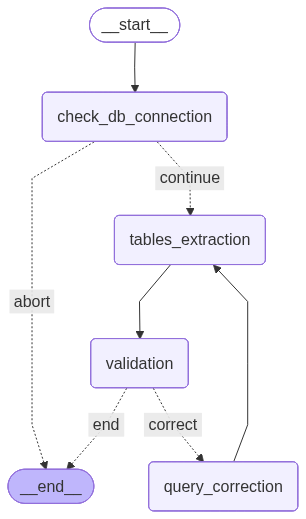

In [10]:
workflow = StateGraph(
    state_schema= QueryValidatorState,
    input_schema= QueryValidatorState,
    output_schema= QueryValidatorOutputState
)


workflow.add_node(
    'check_db_connection',
    check_db_connection_node
)
workflow.add_node(
    'tables_extraction',
    table_name_extraction_node
)
workflow.add_node(
    'validation',
    coherence_grading_node
)
workflow.add_node(
    'query_correction',
    query_correction_node
)


workflow.add_edge(START, 'check_db_connection')
workflow.add_conditional_edges(
    'check_db_connection',
    lambda state: 'abort' if state['db'] is None else 'continue',
    {
        'abort': END,
        'continue': 'tables_extraction'
    }
)
workflow.add_edge('tables_extraction', 'validation')
workflow.add_conditional_edges(
    'validation',
    lambda state: 'correct' if state.get('valid_query_execution') is None else 'end',
    {
        'correct': 'query_correction',
        'end': END
    }
)
workflow.add_edge('query_correction', 'tables_extraction')

graph = workflow.compile()

Image(graph.get_graph().draw_mermaid_png())


## 7. Simulacion de casos del flujo de trabajo

### A. query coherente sin fallo en la BBDD

In [11]:
user_msg_ok = "Quiero saber cuántos clientes hay en total."
query_ok = "SELECT COUNT(*) FROM sales.dim_customer"
high_level_summary = "###Detalle de Tablas y Columnas Relevantes\n#### Tabla: dim_customer\n- *Descripción:* Contiene información detallada de clientes.\n- *Columnas Relevantes:\n  - customer_key: Clave primaria, tipo NUMERIC.\n  - customer_full_name: Nombre completo del cliente, tipo TEXT.\n\n#### Tabla: fact_sales\n- **Descripción:* Contiene detalles de las órdenes de ventas.\n- *Columnas Relevantes:*\n  - customer_key: Llave foránea, tipo NUMERIC.\n  - sales_amount: Subtotal de la línea de orden de venta, tipo NUMERIC.\n  - order_date: Fecha de creación del pedido, tipo DATE.\n"
inputs = {"user_message": user_msg_ok, "sql_query": query_ok, "high_level_summary": high_level_summary, "retries": 0}

results = graph.invoke({
    "user_query": user_msg_ok, 
    "sql_query": query_ok, 
    "context": high_level_summary,
    "db_name": "adventure_works_dw",
    "schema_name": "sales"
})

results


--- INICIANDO COMPROBACIÓN DE CONEXIÓN A BBDD ⚙️ ---
✅ Conexión a la base de datos establecida correctamente.

--- INICIANDO FASE DE EXTRACCIÓN DE TABLAS CON LLM 🧮 ---
Tablas detectadas por el LLM: ['dim_customer']

--- INICIANDO FASE DE JUEZ DE COHERENCIA 👩‍⚖️ ---

Veredicto del juez: COHERENTE ✅

--- PASANDO A FASE DE EJECUCIÓN EN POSTGRESQL ---


✅ Query ejecutada correctamente.


{'sql_query': 'SELECT COUNT(*) FROM sales.dim_customer',
 'table_names': ['dim_customer'],
 'tables_info': ['\nCREATE TABLE dim_customer (\n\tcustomer_key INTEGER NOT NULL, \n\tgeography_key INTEGER, \n\tcustomer_full_name TEXT, \n\tbirth_date DATE, \n\tmarital_status CHAR(1), \n\tgender VARCHAR(1), \n\tyearly_income NUMERIC(19, 4), \n\ttotal_children SMALLINT, \n\tnumber_children_at_home SMALLINT, \n\tenglish_education VARCHAR(40), \n\tspanish_education VARCHAR(40), \n\tenglish_occupation VARCHAR(100), \n\tspanish_occupation VARCHAR(100), \n\thouse_owner BOOLEAN, \n\tnumber_cars_owned SMALLINT, \n\tcommute_distance VARCHAR(15), \n\tCONSTRAINT dim_customer_pkey PRIMARY KEY (customer_key), \n\tCONSTRAINT fk_dim_customer_geography FOREIGN KEY(geography_key) REFERENCES dim_geography (geography_key)\n)\n\n/*\n3 rows from dim_customer table:\ncustomer_key\tgeography_key\tcustomer_full_name\tbirth_date\tmarital_status\tgender\tyearly_income\ttotal_children\tnumber_children_at_home\tenglish_e

### B. Corrección por Incoherencia Semántica

In [12]:
# Escenario de incoherencia semántica: Query no relacionada con la pregunta
user_msg_ko_coherencia = "Quiero ver los nombres de los clientes.(solo 10)"
query_ko_coherencia = "SELECT sales_amount FROM sales.fact_sales limit 10" # Coherente sintácticamente, incoherente semánticamente
high_level_summary = "###Detalle de Tablas y Columnas Relevantes\n#### Tabla: dim_customer\n- *Descripción:* Contiene información detallada de clientes.\n- *Columnas Relevantes:\n  - customer_key: Clave primaria, tipo NUMERIC.\n  - customer_full_name: Nombre y apellido del cliente, tipo TEXT.n\n#### Tabla: fact_sales\n- **Descripción:* Contiene detalles de las órdenes de ventas.\n- *Columnas Relevantes:*\n  - customer_key: Llave foránea, tipo NUMERIC.\n  - sales_amount: Subtotal de la línea de orden de venta, tipo NUMERIC.\n  - order_date: Fecha de creación del pedido, tipo DATE.\n"

results = graph.invoke({
    "user_query": user_msg_ko_coherencia, 
    "sql_query": query_ko_coherencia, 
    "context": high_level_summary,
    "db_name": "adventure_works_dw",
    "schema_name": "sales"
})

results


--- INICIANDO COMPROBACIÓN DE CONEXIÓN A BBDD ⚙️ ---
✅ Conexión a la base de datos establecida correctamente.

--- INICIANDO FASE DE EXTRACCIÓN DE TABLAS CON LLM 🧮 ---
Tablas detectadas por el LLM: ['fact_sales']

--- INICIANDO FASE DE JUEZ DE COHERENCIA 👩‍⚖️ ---

Veredicto del juez: INCOHERENTE ❌

❌ La query es incoherente. No se ejecutará en la BBDD.

--- INICIANDO FASE DE CORRECIÓN 📝 ---

✅  > Query corregida recibida: SELECT customer_full_name FROM sales.dim_customer LIMIT 10...

--- INICIANDO FASE DE EXTRACCIÓN DE TABLAS CON LLM 🧮 ---
Tablas detectadas por el LLM: ['dim_customer']

--- INICIANDO FASE DE JUEZ DE COHERENCIA 👩‍⚖️ ---

Veredicto del juez: COHERENTE ✅

--- PASANDO A FASE DE EJECUCIÓN EN POSTGRESQL ---


✅ Query ejecutada correctamente.


{'sql_query': 'SELECT customer_full_name FROM sales.dim_customer LIMIT 10',
 'table_names': ['dim_customer'],
 'tables_info': ['\nCREATE TABLE dim_customer (\n\tcustomer_key INTEGER NOT NULL, \n\tgeography_key INTEGER, \n\tcustomer_full_name TEXT, \n\tbirth_date DATE, \n\tmarital_status CHAR(1), \n\tgender VARCHAR(1), \n\tyearly_income NUMERIC(19, 4), \n\ttotal_children SMALLINT, \n\tnumber_children_at_home SMALLINT, \n\tenglish_education VARCHAR(40), \n\tspanish_education VARCHAR(40), \n\tenglish_occupation VARCHAR(100), \n\tspanish_occupation VARCHAR(100), \n\thouse_owner BOOLEAN, \n\tnumber_cars_owned SMALLINT, \n\tcommute_distance VARCHAR(15), \n\tCONSTRAINT dim_customer_pkey PRIMARY KEY (customer_key), \n\tCONSTRAINT fk_dim_customer_geography FOREIGN KEY(geography_key) REFERENCES dim_geography (geography_key)\n)\n\n/*\n3 rows from dim_customer table:\ncustomer_key\tgeography_key\tcustomer_full_name\tbirth_date\tmarital_status\tgender\tyearly_income\ttotal_children\tnumber_children

### C. Corrección de Fallo en la BBDD

In [13]:
# Escenario de error en BBDD: Tabla con nombre incorrecto
user_msg_ko_db = "Quiero saber el total de clientes por genero."
query_ko_db = "SELECT gender, COUNT(*) AS total_clients FROM sales.dimen_customer GROUP BY gender" # Nombre de tabla incorrecto
high_level_summary = "###Detalle de Tablas y Columnas Relevantes\n#### Tabla: dim_customer\n- *Descripción:* Contiene información detallada de clientes.\n- *Columnas Relevantes:\n  - customer_key: Clave primaria, tipo NUMERIC.\n  - gender: genero del cliente, tipo TEXT.\n\n#### Tabla: fact_sales\n- **Descripción:* Contiene detalles de las órdenes de ventas.\n- *Columnas Relevantes:*\n  - customer_key: Llave foránea, tipo NUMERIC.\n  - sales_amount: Subtotal de la línea de orden de venta, tipo NUMERIC.\n  - order_date: Fecha de creación del pedido, tipo DATE.\n"

results = graph.invoke({
    "user_query": user_msg_ko_db, 
    "sql_query": query_ko_db, 
    "context": high_level_summary,
    "db_name": "adventure_works_dw",
    "schema_name": "sales"
})

results


--- INICIANDO COMPROBACIÓN DE CONEXIÓN A BBDD ⚙️ ---
✅ Conexión a la base de datos establecida correctamente.

--- INICIANDO FASE DE EXTRACCIÓN DE TABLAS CON LLM 🧮 ---
Tablas detectadas por el LLM: ['dimen_customer']

--- INICIANDO FASE DE JUEZ DE COHERENCIA 👩‍⚖️ ---

Veredicto del juez: COHERENTE ✅

--- PASANDO A FASE DE EJECUCIÓN EN POSTGRESQL ---


❌ Error de PostgreSQL detectado: table_names {'dimen_customer'} not found in database

--- INICIANDO FASE DE CORRECIÓN 📝 ---

✅  > Query corregida recibida: SELECT dim_customer.gender, COUNT(*) AS total_clients FROM sales.dim_c...

--- INICIANDO FASE DE EXTRACCIÓN DE TABLAS CON LLM 🧮 ---
Tablas detectadas por el LLM: ['dim_customer']

--- INICIANDO FASE DE JUEZ DE COHERENCIA 👩‍⚖️ ---

Veredicto del juez: INCOHERENTE ❌

❌ La query es incoherente. No se ejecutará en la BBDD.

--- INICIANDO FASE DE CORRECIÓN 📝 ---

✅  > Query corregida recibida: SELECT sales.dim_customer.gender, COUNT(*) AS total_clients FROM sales...

--- INICIANDO FASE DE

{'sql_query': 'SELECT sales.dim_customer.gender, COUNT(*) AS total_clients FROM sales.dim_customer GROUP BY sales.dim_customer.gender;',
 'table_names': ['dim_customer'],
 'tables_info': ['\nCREATE TABLE dim_customer (\n\tcustomer_key INTEGER NOT NULL, \n\tgeography_key INTEGER, \n\tcustomer_full_name TEXT, \n\tbirth_date DATE, \n\tmarital_status CHAR(1), \n\tgender VARCHAR(1), \n\tyearly_income NUMERIC(19, 4), \n\ttotal_children SMALLINT, \n\tnumber_children_at_home SMALLINT, \n\tenglish_education VARCHAR(40), \n\tspanish_education VARCHAR(40), \n\tenglish_occupation VARCHAR(100), \n\tspanish_occupation VARCHAR(100), \n\thouse_owner BOOLEAN, \n\tnumber_cars_owned SMALLINT, \n\tcommute_distance VARCHAR(15), \n\tCONSTRAINT dim_customer_pkey PRIMARY KEY (customer_key), \n\tCONSTRAINT fk_dim_customer_geography FOREIGN KEY(geography_key) REFERENCES dim_geography (geography_key)\n)\n\n/*\n3 rows from dim_customer table:\ncustomer_key\tgeography_key\tcustomer_full_name\tbirth_date\tmarital_s

### D. Ejemplo complejo:

In [14]:
user_query = 'Muéstrame los 10 productos más vendidos para el B2B en el último trimestre, excluyendo los Accesorios. Mes a mes indica cuántas unidades se vendieron, y muestra también a qué categoría y subcategoría pertenecen'
sql_query = "WITH \nlast_quarter AS (\n  SELECT\n    fs.product_key,\n    COALESCE(dp.spanish_product_name, dp.english_product_name) AS product_name,\n    dp.spanish_product_category_name,\n    dp.spanish_product_subcategory_name,\n    EXTRACT(MONTH FROM fs.order_date) AS month_in_quarter,\n    fs.order_quantity\n  FROM\n    sales.ventas fs\n    JOIN sales.productos dp ON fs.product_key = dp.product_key\n  WHERE\n    fs.sale_source = 'reseller_sales'\n    AND dp.spanish_product_category_name <> 'Accesorio'\n    AND fs.order_date >= date_trunc('quarter', CURRENT_DATE - interval '3 months')\n    AND fs.order_date < date_trunc('quarter', CURRENT_DATE)\n),\ntop_products AS (\n  SELECT\n    product_key,\n    product_name,\n    spanish_product_category_name,\n    spanish_product_subcategory_name,\n    SUM(order_quantity) AS total_qty\n  FROM\n    last_quarter\n  GROUP BY\n    product_key, product_name, spanish_product_category_name, spanish_product_subcategory_name\n  ORDER BY\n    total_qty DESC\n  LIMIT 10\n)\nSELECT\n  tp.product_name AS producto,\n  tp.spanish_product_category_name AS categoria,\n  tp.spanish_product_subcategory_name AS subcategoria,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months'))) AS primer_mes,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months') + interval '1 month')) AS segundo_mes,\n  SUM(lq.order_quantity) FILTER (WHERE lq.month_in_quarter = EXTRACT(MONTH FROM date_trunc('quarter', CURRENT_DATE - interval '3 months') + interval '2 month')) AS tercer_mes,\n  SUM(lq.order_quantity) AS total\nFROM\n  top_products tp\n  LEFT JOIN last_quarter lq ON tp.product_key = lq.product_key\nGROUP BY\n  producto, categoria, subcategoria\nORDER BY\n  total DESC"
context = "### Resumen General\nEl objetivo de la consulta es identificar los 10 productos más vendidos en el modelo de negocio B2B durante el último trimestre, excluyendo aquellos clasificados como accesorios. Además, se requiere un desglose mensual de las unidades vendidas y la inclusión de información sobre la categoría y subcategoría de cada producto.\n\n### Esquema Detallado y Relaciones\n#### Base de datos y esquema\n- **Base de datos:** adventure_works_dw\n- **Esquema:** sales\n\n#### Tabla: dim_product\n- **Descripción:** Contiene información detallada de los productos vendidos.\n- **Clave primaria:** product_key\n- **Columnas relevantes:**\n  - **english_product_category_name**: VARCHAR(50), nunca NULL.\n  - **spanish_product_category_name**: VARCHAR(50), nunca NULL.\n  - **english_product_subcategory_name**: VARCHAR(50), nunca NULL.\n  - **spanish_product_subcategory_name**: VARCHAR(50), nunca NULL.\n  - **spanish_product_name**: VARCHAR(50), puede ser NULL.\n  - **english_product_name**: VARCHAR(50), nunca NULL.\n  - **finished_goods_flag**: BOOL.\n  - **start_date**: DATE.\n  - **end_date**: DATE, puede ser NULL.\n  - **dealer_price**: NUMERIC.\n  - **list_price**: NUMERIC.\n\n#### Tabla: fact_sales\n- **Descripción:** Contiene detalles de las órdenes de ventas realizadas.\n- **Clave primaria:** sales_order_number, sales_order_line_number\n- **Claves foráneas:**\n  - product_key → sales.dim_product.product_key\n- **Columnas relevantes:**\n  - **order_quantity**: INT2.\n  - **sale_source**: TEXT.\n  - **order_date**: DATE.\n  - **product_key**: Referencia a sales.dim_product.product_key.\n\n#### Relaciones entre tablas\n- Para unir las tablas **fact_sales** y **dim_product**, se utiliza la clave foránea **product_key**.\n- Condiciones de unión: `fact_sales.product_key = dim_product.product_key`.\n\n### Reglas de Negocio y Lógica\n1. **Modelo de Negocio B2B:**\n   - Las ventas B2B se identifican con el campo `sale_source` igual a `'reseller_sales'`.\n\n2. **Productos Más Vendidos:**\n   - Se define por la cantidad de unidades vendidas (`order_quantity`).\n   - Implementación SQL:\n     ```sql\n     SUM(order_quantity) AS cantidad_vendida\n     ```\n\n3. **Exclusión de Accesorios:**\n   - Se aplica el filtro `spanish_product_category_name != 'Accesorio'`.\n\n4. **Desglose Temporal:**\n   - Para calcular el último trimestre, se utiliza el campo `order_date` en la tabla `fact_sales`.\n   - Ejemplo de filtro SQL para el último trimestre:\n     ```sql\n     WHERE order_date BETWEEN DATE_TRUNC('quarter', CURRENT_DATE - INTERVAL '3 months') AND DATE_TRUNC('quarter', CURRENT_DATE) - INTERVAL '1 day';\n     ```\n   - Para el desglose mensual, se puede usar la función `EXTRACT(MONTH FROM order_date)`.\n\n5. **Categorías y Subcategorías:**\n   - Para mostrar nombres de categorías y subcategorías, se priorizan los campos en español (`spanish_product_category_name`, `spanish_product_subcategory_name`). Si son nulos, se utiliza la versión en inglés como alternativa.\n   - Ejemplo de lógica SQL:\n     ```sql\n     SELECT\n         COALESCE(spanish_product_category_name, english_product_category_name) AS producto_categoria,\n         COALESCE(spanish_product_subcategory_name, english_product_subcategory_name) AS producto_subcategoria\n     FROM sales.dim_product;\n     ```"

results = graph.invoke({
    "user_query": user_query, 
    "sql_query": sql_query, 
    "context": context,
    "db_name": "adventure_works_dw",
    "schema_name": "sales"
})

results


--- INICIANDO COMPROBACIÓN DE CONEXIÓN A BBDD ⚙️ ---
✅ Conexión a la base de datos establecida correctamente.

--- INICIANDO FASE DE EXTRACCIÓN DE TABLAS CON LLM 🧮 ---
Tablas detectadas por el LLM: ['ventas', 'productos']

--- INICIANDO FASE DE JUEZ DE COHERENCIA 👩‍⚖️ ---

Veredicto del juez: COHERENTE ✅

--- PASANDO A FASE DE EJECUCIÓN EN POSTGRESQL ---


❌ Error de PostgreSQL detectado: table_names {'ventas'} not found in database

--- INICIANDO FASE DE CORRECIÓN 📝 ---

✅  > Query corregida recibida: WITH 
last_quarter AS (
  SELECT
    fs.product_key,
    COALESCE(dp.s...

--- INICIANDO FASE DE EXTRACCIÓN DE TABLAS CON LLM 🧮 ---
Tablas detectadas por el LLM: ['fact_sales', 'dim_product']

--- INICIANDO FASE DE JUEZ DE COHERENCIA 👩‍⚖️ ---

Veredicto del juez: COHERENTE ✅

--- PASANDO A FASE DE EJECUCIÓN EN POSTGRESQL ---


✅ Query ejecutada correctamente.


{'sql_query': "WITH \nlast_quarter AS (\n  SELECT\n    fs.product_key,\n    COALESCE(dp.spanish_product_name, dp.english_product_name) AS product_name,\n    dp.spanish_product_category_name,\n    dp.spanish_product_subcategory_name,\n    EXTRACT(MONTH FROM fs.order_date) AS month_in_quarter,\n    fs.order_quantity\n  FROM\n    sales.fact_sales fs\n    JOIN sales.dim_product dp ON fs.product_key = dp.product_key\n  WHERE\n    fs.sale_source = 'reseller_sales'\n    AND dp.spanish_product_category_name <> 'Accesorio'\n    AND fs.order_date >= date_trunc('quarter', CURRENT_DATE - interval '3 months')\n    AND fs.order_date < date_trunc('quarter', CURRENT_DATE)\n),\ntop_products AS (\n  SELECT\n    product_key,\n    product_name,\n    spanish_product_category_name,\n    spanish_product_subcategory_name,\n    SUM(order_quantity) AS total_qty\n  FROM\n    last_quarter\n  GROUP BY\n    product_key, product_name, spanish_product_category_name, spanish_product_subcategory_name\n  ORDER BY\n    t